                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


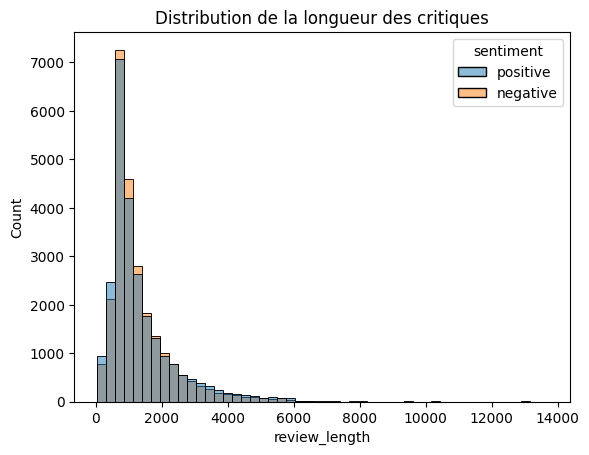

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Charger le dataset
df = pd.read_csv("IMDB Dataset.csv")

# Aperçu
print(df.head())
print(df['sentiment'].value_counts())

# Longueur des critiques
df['review_length'] = df['review'].apply(len)
sns.histplot(data=df, x='review_length', hue='sentiment', bins=50)
plt.title("Distribution de la longueur des critiques")
plt.show()

In [12]:
import nltk
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Fonction de nettoyage
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # balises HTML
    text = re.sub(r'http\S+|www\S+', '', text)  # URLs
    tokens = re.findall(r'\b\w+\b', text)
    filtered = [word for word in tokens if word not in stop_words]
    return " ".join(filtered)

# Application
df['cleaned_review'] = df['review'].apply(clean_text)

# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_review']).toarray()
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Split
# Étape 1 : d'abord un split train+val / test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Étape 2 : ensuite un split train / val
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2



[nltk_data] Downloading package stopwords to C:\Users\BAN
[nltk_data]     CYRILLE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout


model = Sequential([
    Input(shape=(X_train.shape[1],)),       # Couche d'entrée
    Dense(64, activation='relu'),          # 1ère couche cachée
    Dropout(0.5),                            # Dropout après la 1ère couche
    Dense(32, activation='relu'),           # 2e couche cachée
    Dropout(0.5),                            # Dropout après la 2e couche
    Dense(1, activation='sigmoid')          # Couche de sortie pour binaire
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',    # surveille la perte de validation
    patience=5,            # nombre d'époques à attendre sans amélioration avant d'arrêter
    restore_best_weights=True  # restaurer les poids du meilleur modèle
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)


Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.7601 - loss: 0.4847 - val_accuracy: 0.8874 - val_loss: 0.2692
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9123 - loss: 0.2365 - val_accuracy: 0.8870 - val_loss: 0.2778
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9320 - loss: 0.1914 - val_accuracy: 0.8838 - val_loss: 0.2909
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9479 - loss: 0.1533 - val_accuracy: 0.8811 - val_loss: 0.3142
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.9608 - loss: 0.1182 - val_accuracy: 0.8800 - val_loss: 0.3521
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.9705 - loss: 0.0958 - val_accuracy: 0.8788 - val_loss: 0.4030


In [16]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8909 - loss: 0.2638
Test Loss: 0.2690
Test Accuracy: 0.8883


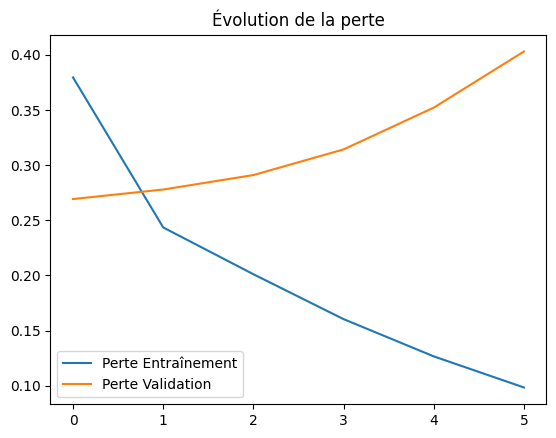

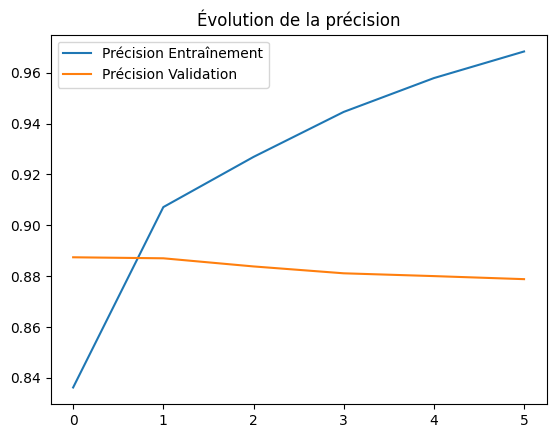

In [17]:
plt.plot(history.history['loss'], label='Perte Entraînement')
plt.plot(history.history['val_loss'], label='Perte Validation')
plt.title("Évolution de la perte")
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Précision Entraînement')
plt.plot(history.history['val_accuracy'], label='Précision Validation')
plt.title("Évolution de la précision")
plt.legend()
plt.show()

In [ ]:
# Analyse de la courbe de perte 

La courbe de la perte d'entraînement diminue régulièrement, ce qui indique que le modèle apprend efficacement les exemples d'entraînement.
Cependant, la perte de validation augmente légèrement avant de se stabiliser, ce qui suggère un début de surapprentissage.
Le modèle commence à mémoriser les données d’entraînement plutôt que de généraliser.

# Analyse de la courbe de précision 

La précision sur les données d’entraînement s’améliore au fil des époques, atteignant un plateau, ce qui est attendu.
En revanche, la précision sur les données de validation reste stable, ce qui peut indiquer que le modèle n’arrive plus à mieux généraliser malgré 
l’entraînement supplémentaire.

Interprétation finale
le modèle a bien appris, mais il atteint rapidement ses limites en termes de généralisation. Ce comportement est typique d’un modèle de base utilisant 
TF-IDF + couches denses.

